Analyzing discord messages is fun.

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

### Data preparation
Load data and do some data preparation.

In [39]:
df = pd.read_csv('chat.csv')
df.drop(columns=['AuthorID', 'Reactions'], inplace=True)
df['Author'] = df['Author'].str.replace(r"#[0-9]+", "")  # leave only usernames

df['Content'] = df['Content'].fillna("")
df.insert(2, 'Time', pd.to_datetime(df['Date']).dt.time)
df['Date'] = pd.to_datetime(df['Date']).dt.date

df.columns

Index(['Author', 'Date', 'Time', 'Content', 'Attachments'], dtype='object')

### Basic information about messages in the dataset

In [40]:
def get_the_highest_streak(msgs_per_day: pd.Series) -> tuple:
    """
    Finds and returns the highest messaging streak found in the dataset.
    Think of it as snapchat fires. But on discord.

    :param msgs_per_day: series where index represents every day when message has been sent
    :return: start of the streak, end of the streak, duration of the streak
    """
    days = msgs_per_day.sort_index().index

    start, end, prev, streak = 0, 0, 0, 0
    max_start, max_end, max_streak = 0, 0, 0
    one_day = pd.DateOffset()

    for day in days:
        if start == 0:
            start, prev = day, day
        elif prev + one_day == day:
            prev = day
            streak += 1
        else:
            streak = streak + 1 if streak != 0 else 0
            end = prev if streak != 0 else 0
            if streak > max_streak:
                max_start, max_end, max_streak = start, end, streak
            start, prev, end, streak = 0, 0, 0, 0

    if streak > max_streak:
        return start, 0, streak

    return max_start, max_end, max_streak

In [41]:
total_msgs = len(df)

messages = df['Author'].value_counts()
author_1, author_2 = messages.index.to_numpy()
msgs_per_author = messages.values

msgs_per_day = df['Date'].value_counts()
max_msg_day, max_msg_cnt = msgs_per_day.index[0], msgs_per_day[0]
msgs_info = msgs_per_day.describe()

start, end, streak = get_the_highest_streak(msgs_per_day)

index = ['Total message count', f"{author_1}'s total message count", f"{author_2}'s total message count",
         'Number of days in dataset',
         'Most messages per day date', 'Most messages per day count',
         'Messages per day mean', 'Messages per day median', 'Messages per day std',
         'Highest message streak (days)', 'Begin of the highest streak', 'End of the highest streak']
data = [total_msgs, msgs_per_author[0], msgs_per_author[1], int(msgs_info[0]),
        max_msg_day, max_msg_cnt,
        msgs_info[1], msgs_info[5], msgs_info[2],
        streak, start, "ongoing" if end == 0 and streak != 0 else end]

basic_info_df = pd.DataFrame(index=index, data=data, columns=['Data'])
basic_info_df

,Data
Total message count,959905
A's total message count,486046
S's total message count,473859
Number of days in dataset,1668
Most messages per day date,2018-01-12
Most messages per day count,2996
Messages per day mean,575.482614
Messages per day median,394.0
Messages per day std,479.946682
Highest message streak (days),1630


### Message count analysis
Analysing the number of messages sent per day.
Since the dataset is quite big, I'll also plot the regression line to get the better idea of the data.

<AxesSubplot:title={'center':'Message count per day'}, xlabel='Day', ylabel='Message count'>

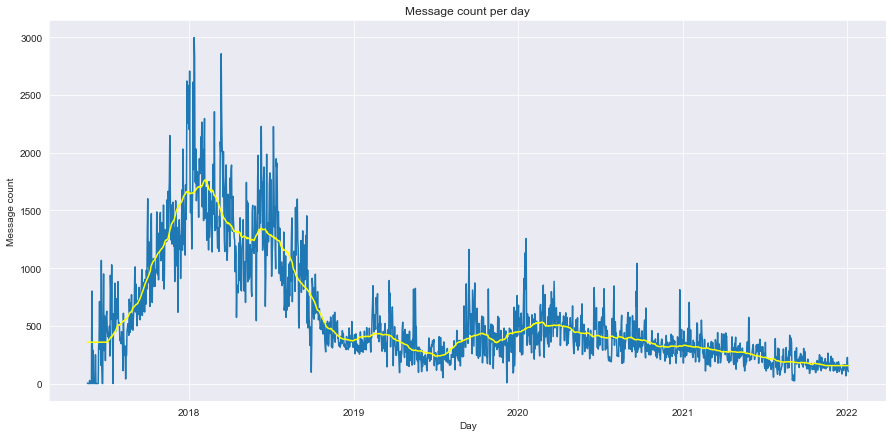

In [42]:
msgs_per_day = pd.DataFrame(msgs_per_day).reset_index()
msgs_per_day.rename(columns={'index': 'Day', 'Date': 'Message count'}, inplace=True)
missing_days = pd.date_range(start=msgs_per_day['Day'].min(), end=msgs_per_day['Day'].max()).difference(
    msgs_per_day['Day']).values
msgs_per_day = pd.concat(
    [msgs_per_day,
     pd.DataFrame(data=[[pd.to_datetime(day).date(), 0] for day in missing_days], columns=['Day', 'Message count'])],
    ignore_index=True)
msgs_per_day.sort_values(by='Day', inplace=True)

plt.figure(figsize=(15, 7))
sns.lineplot('Day', 'Message count', data=msgs_per_day).set_title('Message count per day')

# Plot the regression line
from sklearn.neighbors import KNeighborsRegressor

days = np.array([i for i in range(0, len(msgs_per_day))])

knr = KNeighborsRegressor(n_neighbors=int(0.05 * len(msgs_per_day)), n_jobs=-1, weights='uniform')
knr.fit(X=days.reshape(-1, 1), y=msgs_per_day['Message count'])

predited = knr.predict(days.reshape(-1, 1))
sns.lineplot(msgs_per_day['Day'], predited, color='yellow')


Analysing the number of messages sent each hour during the day.

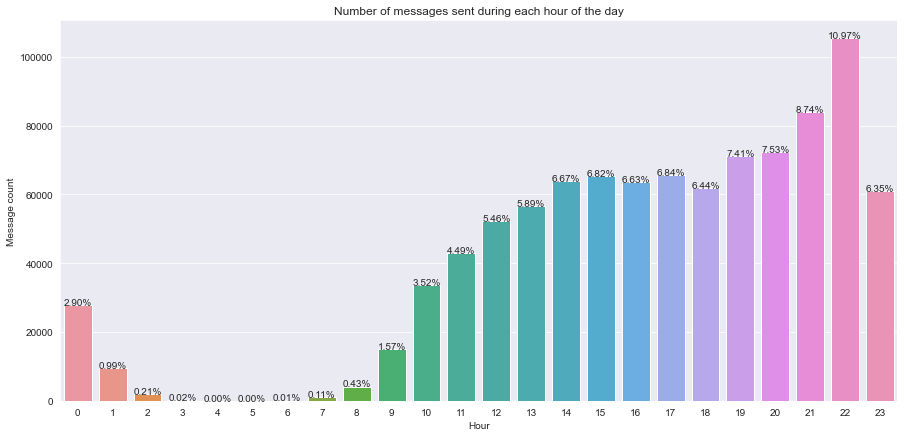

In [43]:
msgs_per_hour = df.groupby(by=['Time'], as_index=False)['Content'].count()
msgs_per_hour['Time'] = pd.to_datetime(msgs_per_hour['Time'].map(lambda t: str(t))) # this is so dumb to do
msgs_per_hour = msgs_per_hour.groupby(pd.Grouper(key='Time', freq='1H')).sum().reset_index()
msgs_per_hour.rename(columns={'Content': 'Message count', 'Time': 'Hour'}, inplace=True)
missing_times = pd.date_range(start='00:00', end='23:00', freq='1H').difference(msgs_per_hour['Hour']).values
msgs_per_hour = pd.concat(
    [msgs_per_hour, pd.DataFrame(data=[[time, 0] for time in missing_times], columns=['Hour', 'Message count'])],
    ignore_index=True)
msgs_per_hour['Hour'] = msgs_per_hour['Hour'].map(lambda t: t.hour)

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='Hour', y='Message count', data=msgs_per_hour)
ax.set_title("Number of messages sent during each hour of the day")

total_msgs = sum(msgs_per_hour['Message count'].to_numpy())

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + 0.05
    ax.annotate('{:.2f}%'.format(msgs_per_hour['Message count'][i] / total_msgs * 100), (x, y), ha='center')
plt.show()

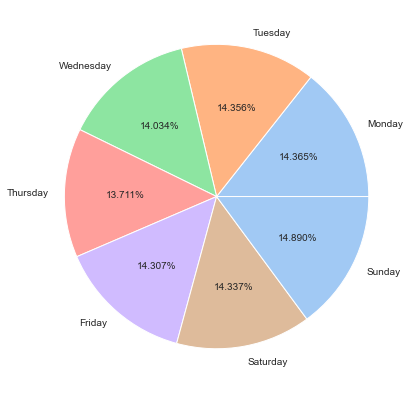

In [44]:
msgs_per_weekday = msgs_per_day.copy(deep=True)
msgs_per_weekday['Day'] = pd.to_datetime(msgs_per_weekday['Day'])
msgs_per_weekday['Day'] = msgs_per_weekday['Day'].map(lambda t: t.weekday())
msgs_per_weekday = msgs_per_weekday.groupby(by=['Day'], as_index=False).sum()
msgs_per_weekday.rename(columns={'Day': 'Day of the week'}, inplace=True)
msgs_per_weekday['Day of the week'] = msgs_per_weekday['Day of the week'].map(
    {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

plt.figure(figsize=(15, 7))
colors = sns.color_palette('pastel')[0:6]
pie = plt.pie(msgs_per_weekday['Message count'], labels=msgs_per_weekday['Day of the week'], colors=colors,
              autopct='%.3f%%')

### The initiator

For this purpose, I'll define the initiator as the person who sends the first message in a day (past 5 AM) to figure out
which person initates the conversations more often.

In [45]:
msg_initiator = df.copy(deep=True)
msg_initiator = msg_initiator[msg_initiator['Time'] > pd.to_datetime('05:00').time()] # assume normal sleep schedule
msg_initiator = msg_initiator.groupby(by=['Date'], as_index=False).first()
msg_initiator['Author'].value_counts()

A    1096
S     571
Name: Author, dtype: int64